In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

%cd "./drive/My Drive/Colab Notebooks/neural-learning"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/neural-learning


# RELIABLE SIGNAL PROPAGATION

In [3]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import copy
import numpy as np
from scipy.signal import find_peaks
import scipy.fftpack
from matplotlib import pyplot as plt
import seaborn as sns
import time

from src.network import Layer, PropagationNetwork, FullyConnectedLayerApprox #, FullyConnectedLayer, PropagationNetworkFC
from src.ou_process import ouprocess_gaussian
from src.experiment import Experiment, MultiVariableExperiment
from src.lif import gaussian_kernel

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def graph_psth(spikes, num_timesteps, save=None, color="#2598B2"):
    graph_size = 5
    sns.set(style="white")
#     sns.set_context("talk", font_scale=2.5)

    plt.figure(figsize=(graph_size, graph_size))
    plt.rc('axes',edgecolor='#FFFFFF')

    in_spike_inds, in_spike_trial = np.where(spikes[:num_timesteps] > 0)
    in_spike_inds = in_spike_inds / float(num_timesteps)

    plt.scatter(in_spike_inds, in_spike_trial, s=6, marker='o', c=color)

    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()

def graph_firing_rates(in_fr, out_fr, num_timesteps, save=None, in_color="#888888", out_color='#189B48'):
    sns.set(style="white")
#     sns.set_context("talk", font_scale=2.5)
    plt.rc('axes',edgecolor='#FFFFFF')

    t = np.arange(0, 1.0, 1e-4)

    plt.figure(figsize=(5,4))
    plt.ylim(top=60)

    plt.plot(t, in_fr.mean(1).numpy()[:num_timesteps], c=in_color, lw=5.0)
    plt.plot(t, out_fr.mean(1).numpy()[:num_timesteps], c=out_color, lw=5.0)

    sns.despine()
    
    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()

In [5]:
NUM_NEURONS = 200
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
train_t_stop = 40.0e3
test_t_stop = 10.0e3

RESULTS_DIR = "./results"
GRAPHS_DIR = "./graphs"

In [16]:
# Slow Signal: INPUT
LOAD_INPUT = True
input_file = "train_input_tau=50_t=40s.npy"
if LOAD_INPUT:
    train_i_inj = np.load(open(os.path.join(RESULTS_DIR, input_file), 'rb'))
else:
    start_time = time.time()
    input_slow, _ = ouprocess_gaussian(50.0, dt, train_t_stop, 1)
    train_i_inj = 16.0 + 6.0*input_slow
    print(time.time() - start_time)
    
    np.save(open(os.path.join(RESULTS_DIR, input_file), 'wb'), train_i_inj)

In [17]:
LOAD_LAYER = True
# load_layer_file = "poc1a__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"
load_layer_file = "reduced_net_ieee"

if LOAD_LAYER:
    layer = Layer.load(RESULTS_DIR, load_layer_file)
else:
    layer = Layer(NUM_NEURONS) # , device="cpu")
    layer.train(i_inj=train_i_inj, exp_output=train_i_inj, dt=dt, t_stop=train_t_stop)
    layer.save(RESULTS_DIR, load_layer_file)

In [18]:
LOAD_TEST_INPUT = True
test_input_file = "test_input_tau=50_t=10s.npy"
if LOAD_TEST_INPUT:
    test_i_inj = np.load(open(os.path.join(RESULTS_DIR, test_input_file), 'rb'))
else:
    start_time = time.time()
    input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
    test_i_inj = 16.0 + 6.0*input_slow
    print(time.time() - start_time)
    
    np.save(open(os.path.join(RESULTS_DIR, test_input_file), 'wb'), test_i_inj)

start_time = time.time()
out, V, F_binary, F_synaptic = layer.output(test_i_inj, dt, test_t_stop)
_, spike_out = layer.spike(out, dt, test_t_stop, int_noise_regen=True)
print(time.time() - start_time)

21.084280014038086


In [10]:
start_time = time.time()
in_fr = layer.firing_rate(F_binary, dt, test_t_stop)
out_fr = layer.firing_rate(spike_out, dt, test_t_stop)
print(time.time() - start_time)

375.24032640457153


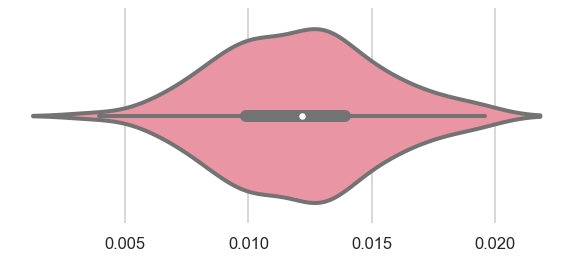

In [11]:
# Weight Distribution

sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.0)
plt.rc('axes',edgecolor='#FFFFFF')
plt.figure(figsize=(10,4))

sns.violinplot(layer.W, linewidth=4, color=sns.xkcd_rgb["rose pink"])
# plt.savefig((os.path.join(GRAPHS_DIR, "rednet_weights.png")))
plt.show()

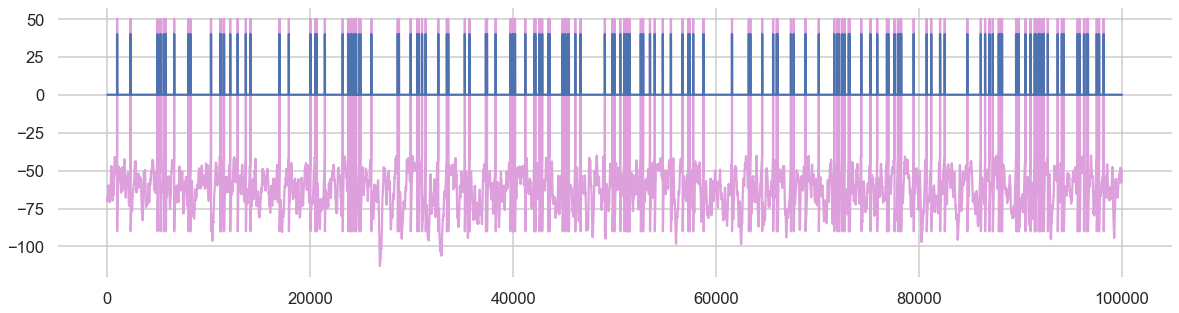

In [12]:
# Voltage + Spike graph

trial = 10
t_i = 0
t_f = -1
plt.figure(figsize=(20,5))
plt.plot(V[t_i:t_f,trial], color='plum')
plt.plot(F_binary[t_i:t_f,trial] * 40.0)
plt.show()

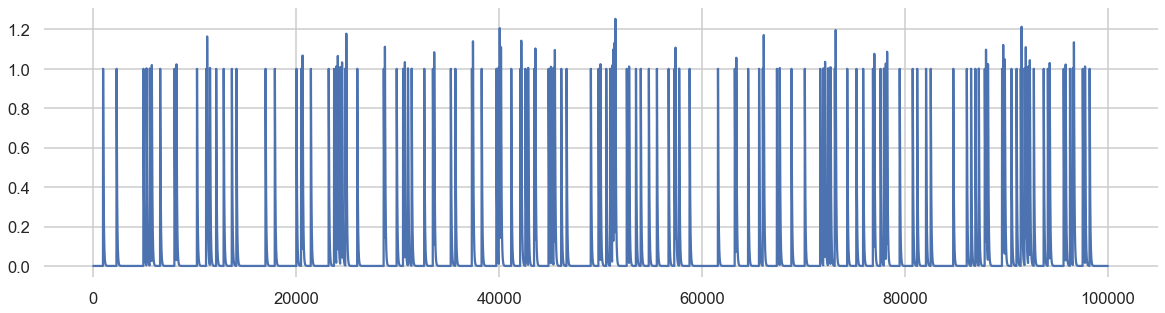

In [13]:
# Synaptic Fct Convolution
plt.figure(figsize=(20,5))
plt.plot(F_synaptic[:,10])
plt.show()

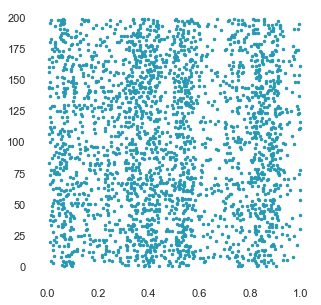

In [14]:
graph_psth(F_binary, 10000) # (os.path.join(GRAPHS_DIR, "verif_fcl_approx_input_spikes.png")

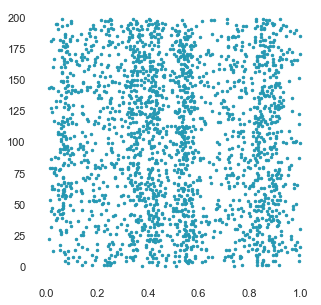

In [15]:
graph_psth(spike_out, 10000) # (os.path.join(GRAPHS_DIR, "verif_fcl_approx_output_spikes.png"))

In [ ]:
np.save(os.path.join(RESULTS_DIR, "reducednet_in_fr"), in_fr.numpy())
np.save(os.path.join(RESULTS_DIR, "reducednet_out_fr"), out_fr.numpy())

In [ ]:
np.save(os.path.join(RESULTS_DIR, "reducednet_out_sig"), out)

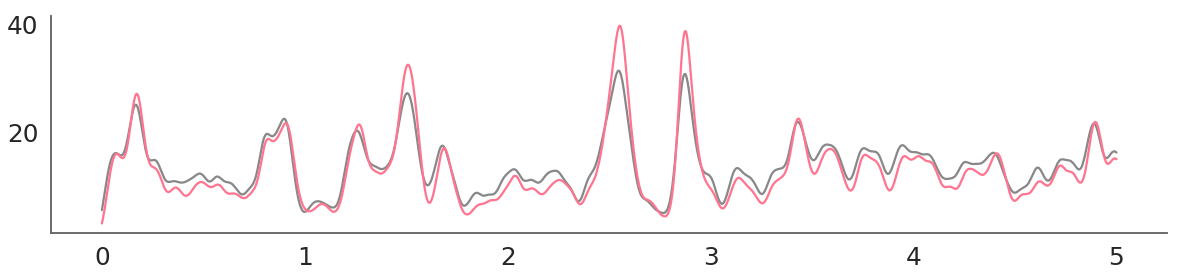

In [25]:
sns.set(style="white")
sns.set_context("talk", font_scale=1.5)
plt.rc('axes',edgecolor='#666666')

t = np.arange(0, 5.0, 1e-4)

plt.figure(figsize=(20,4))
plt.plot(t, in_fr[:50000].mean(1).numpy(), "#888888")
plt.plot(t, out_fr[:50000].mean(1).numpy(), '#FF7590')

# plt.title("Reduced Network: Unconstrained Optimization")
# plt.xlabel("Time (s)")
# plt.ylabel("Inst. Firing Rate (Hz)")

sns.despine()

plt.show()
# plt.savefig((os.path.join(GRAPHS_DIR, "fig4c-fr-redn_unc.png")))

### PoC 1a: Regenerate Internal Noise (Same Input)
For the SAME INPUT, can we shuffle / regenerate internal noise?

In [ ]:
LOAD_POC_1A = True
load_poc_1a_file = "poc1a__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"

test_t_stop = 5000.0

if LOAD_POC_1A:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1a_file)
else:
    NUM_TRIALS = 200

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        inputs[:,i] = layer.train_input.flatten()[num_t*2:num_t*3]

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_poc_1a_file)

In [ ]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

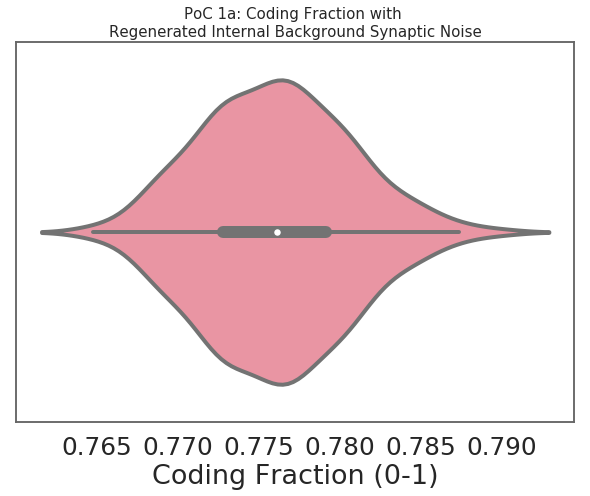

In [30]:
plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 1a: Coding Fraction with \nRegenerated Internal Background Synaptic Noise', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig((os.path.join(GRAPHS_DIR, load_poc_1a_file + ".png")))

### PoC 1b: W=N(u,sig) (Same Input)
SAME INPUT: Can we approximate weights as N(u, sig)? How does this affect reconstruction?

In [ ]:
LOAD_POC_1B = True
load_poc_1b_file = "poc1b__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"

In [ ]:
test_t_stop = 5000.0

if LOAD_POC_1B:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1b_file)
else:
    NUM_TRIALS = 200

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        inputs[:,i] = layer.train_input.flatten()[num_t*2:num_t*3]

    layer_shuffle = copy.deepcopy(layer)

    mean_weight = np.mean(layer_shuffle.W)
    std_weight = np.std(layer_shuffle.W)

    experiment = Experiment(inputs, layer_shuffle, NUM_TRIALS, dt, test_t_stop)

    for trial in range(NUM_TRIALS):
        experiment.layer.W = np.random.normal(mean_weight, std_weight, experiment.layer.W.shape)
        experiment.one_trial(trial, int_noise_regen=False)
    experiment.save(RESULTS_DIR, load_poc1b_file)

In [ ]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 1b: Coding Fraction with \n Weights sampled from N(u, s)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc1b_file + ".png"))

### PoC 2a: Regenerate Internal Noise (Diff Input)
DIFFERENT INPUTS: shuffle internal noise, how does this affect reconstruction?

In [ ]:
LOAD_POC_2A = True
load_poc_2a_file = "poc2a__neurons=200__trials=200__input=tau_50_regenerated__t_stop=5000_msecs"

In [ ]:
if LOAD_POC_2A:
    experiment = Experiment.load(RESULTS_DIR, load_poc_2a_file)
else:
    NUM_TRIALS = 200
    test_t_stop = 5000.0

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_poc_2a_file)

In [ ]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc_2a_file + ".png"))

### PoC 2b: W=N(u,sig) (Different Input)
DIFFERENT INPUTS: shuffle weights, how does this affect reconstruction?

In [ ]:
LOAD_POC_2B = True
load_poc_2b_file = "poc2b__neurons=200__trials=200__input=tau_50_regenerated__t_stop=5000_msecs"

In [ ]:
if LOAD_POC_2B:
    experiment = Experiment.load(RESULTS_DIR, load_poc_2b_file)
else:
    NUM_TRIALS = 200
    test_t_stop = 5000.0

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    layer_shuffle = copy.deepcopy(layer)

    mean_weight = np.mean(layer_shuffle.W)
    std_weight = np.std(layer_shuffle.W)

    experiment = Experiment(inputs, layer_shuffle, NUM_TRIALS, dt, test_t_stop)

    for trial in range(NUM_TRIALS):
        experiment.layer.W = np.random.normal(mean_weight, std_weight, experiment.layer.W.shape)
        experiment.one_trial(trial, int_noise_regen=False)
    experiment.save(RESULTS_DIR, load_poc_2b_file)

In [ ]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 2b: Coding Fraction with Weights sampled from N(u, s):\n Regenerated Inputs from OU(tau=50)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

# plt.show()
plt.savefig(os.path.join(GRAPHS_DIR, load_poc_2b_file + ".png"))

### PoC3a: Biologically Plausible Noise; Network Size = 200

In [ ]:
LOAD_POC_3a = True
load_poc_3a_file = "poc3a__neurons=200__bg-syn-noise={10-50pA-s=5}__trials=20__input=tau_50_regenerated__t_stop=5000_msecs"

In [ ]:
NUM_TRIALS = 20

NOISE_SMALL = 0
NOISE_LARGE = 50
NOISE_STEP = 5

NETWORK_SIZE=200

int_noises = [float(i) for i in range(NOISE_SMALL, NOISE_LARGE+1, NOISE_STEP)]
variables = {
    'int_noise': int_noises
}

# test_t_stop = 5000.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]

if LOAD_POC_3a:
    mve = MultiVariableExperiment.load(RESULTS_DIR, load_poc_3a_file)
else:
    inputs = np.empty((num_t, NUM_TRIALS))
    input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
    for trial in range(NUM_TRIALS):
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,trial] = i_inj.flatten()

    mve = MultiVariableExperiment(variables, NUM_TRIALS, dt, test_t_stop)

    for int_noise in int_noises:
        test_layer = Layer(NUM_NEURONS, std_noise=int_noise)
        test_layer.train(train_i_inj, train_i_inj, dt, train_t_stop)
        multi_values = {'int_noise': int_noise}
        mve.one_experiment(multi_values, inputs, test_layer, RESULTS_DIR, load_poc_3a_file)
    
    mve.save(RESULTS_DIR, load_poc_3a_file)

In [34]:
mve.var_values_dict

{'00bf0206-97c0-4c2c-bf3a-eac49cfdce6d': {'int_noise': 45.0},
 '030b79a1-11f7-41ac-b0ce-cef579dbc89f': {'int_noise': 0.0},
 '22d20b96-4254-4600-95d5-642bd467ad08': {'int_noise': 20.0},
 '2b1032f4-a8f4-4899-ab65-09a2785cfcd8': {'int_noise': 35.0},
 '6c1c2a07-c705-4aa3-bb1e-1ea63fd52a6a': {'int_noise': 15.0},
 'a3c5269a-4b73-416f-9820-d681c5c9b4c8': {'int_noise': 5.0},
 'a4e503be-c7af-4cee-9900-f370ee219f8d': {'int_noise': 25.0},
 'ca174677-18e1-4b59-abc0-506a5d0c8980': {'int_noise': 30.0},
 'cd82e2ab-42ff-47c5-94a7-9f838d767354': {'int_noise': 50.0},
 'd23235c8-20af-40c6-9a77-7d87ab1f2db8': {'int_noise': 10.0},
 'fc7a6aef-714f-4e24-b8bf-aa51b8238808': {'int_noise': 40.0}}

In [ ]:
exp_uuid = 'a4e503be-c7af-4cee-9900-f370ee219f8d'
exp = mve.load_one_experiment(RESULTS_DIR, load_poc_3a_file, exp_uuid)

In [40]:
np.percentile(exp.layer.W, [0,50,100])

array([0.00421136, 0.01176044, 0.02209852])

In [ ]:
noise_vs_efficiency = []
noise = []
for exp_uuid in mve.var_values_dict:
    exp = mve.load_one_experiment(RESULTS_DIR, load_poc_3a_file, exp_uuid)
    efficiencies = []

    for i in range(exp.num_trials):
        efficiencies += [1.0 - np.linalg.norm(exp.outputs[:, i]-exp.inputs[:, i])/np.linalg.norm(exp.inputs[:, i])]
    
    noise += [mve.var_values_dict[exp_uuid]['int_noise']]
    noise_vs_efficiency += [efficiencies]

In [ ]:
noise_x_axis = []
for n in range(len(noise_vs_efficiency)):
    for e in range(len(noise_vs_efficiency[n])):
        noise_x_axis.append(noise[n])

In [53]:
np.mean(noise_vs_efficiency, axis=1)

array([0.        , 0.03818748, 0.27145498, 0.52951055, 0.68907942,
       0.76822901, 0.79628836, 0.79650789, 0.78975124, 0.77802799,
       0.76573666])

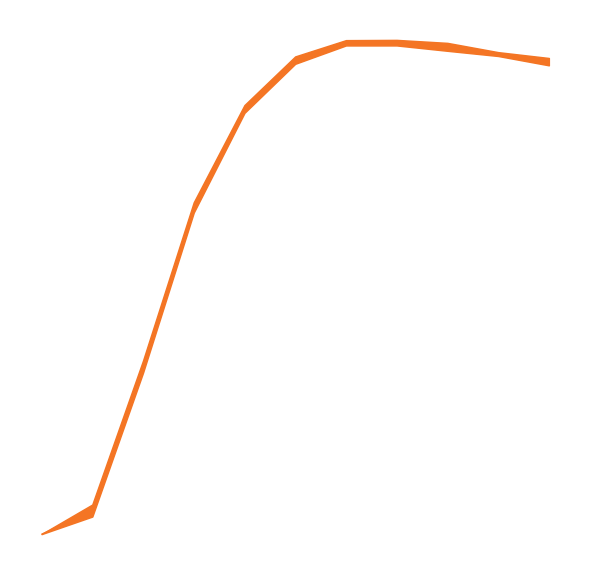

In [54]:
plt.figure(figsize=(10,10))
sns.set(style="white")
sns.set_context("talk", font_scale=1.5)
plt.rc('axes',edgecolor='#FFFFFF')

ax = sns.lineplot(x=np.array(noise_x_axis), y=np.array(noise_vs_efficiency).flatten(),
             linewidth=1, color='#F47524', ci='sd', err_style='band')

ax.get_children()[0].set_alpha(1.0)
plt.xticks([])
plt.yticks([])

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc_3a_file + ".png"))

### PoC 3b: Biologically Plausible Network Size; Noise=25pA

In [ ]:
LOAD_POC_3b = True
load_poc_3b_file = "poc3b__neurons={50-500-s=50}__bg-syn-noise=25pA__trials=20__input=tau_50_regenerated__t_stop=5000_msecs"

In [ ]:
NUM_TRIALS = 20

NETWORK_SMALL = 50
NETWORK_LARGE = 500
NETWORK_STEP = 50

# NETWORK_SIZE=200

network_sizes = [i for i in range(NETWORK_SMALL, NETWORK_LARGE+1, NETWORK_STEP)]
variables = {
    'network_size': network_sizes
}

test_t_stop = 5000.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]

if LOAD_POC_3b:
    mve_net = MultiVariableExperiment.load(RESULTS_DIR, load_poc_3b_file)
else:
    inputs = np.empty((num_t, NUM_TRIALS))
    input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
    for trial in range(NUM_TRIALS):
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,trial] = i_inj.flatten()

    mve_net = MultiVariableExperiment(variables, NUM_TRIALS, dt, test_t_stop)

    for network_size in network_sizes:
        test_layer = Layer(network_size)
        test_layer.train(train_i_inj, train_i_inj, dt, train_t_stop)
        multi_values = {'network_size': network_size}
        mve_net.one_experiment(multi_values, inputs, test_layer, RESULTS_DIR, load_poc_3b_file)
    
    mve_net.save(RESULTS_DIR, load_poc_3b_file)

In [ ]:
noise_vs_efficiency = []
noise = []
for exp_uuid in mve_net.var_values_dict:
    exp = mve_net.load_one_experiment(RESULTS_DIR, load_poc_3b_file, exp_uuid)
    if exp is None:
        continue
#     print(exp.layer.NUM_NEURONS)
#     print(mve_net.var_values_dict[exp_uuid]['network_size'])
#     print("\n")
    efficiencies = []

    for i in range(exp.num_trials):
        efficiencies += [1.0 - np.linalg.norm(exp.outputs[:, i]-exp.inputs[:, i])/np.linalg.norm(exp.inputs[:, i])]
#         efficiencies += [np.linalg.norm(exp.outputs[:, i]-exp.inputs[:, i])]
#         efficiencies += [(np.square(A - B)).mean(axis=ax)]
    
    noise += [mve_net.var_values_dict[exp_uuid]['network_size']]
    noise_vs_efficiency += [efficiencies]

In [ ]:
np.mean(noise_vs_efficiency, axis=1)

### PoC 3: Biologically plausible characteristics
Find biologically plausible region of MSE(N, std) graph

noise and network size:
    network size = [20-1000, step=50 (or 100)]
    noise = [10 -- 50, step=5]

each presynaptic spike through synaptic waveform * 

In [ ]:
LOAD_POC_3 = False
load_poc_3_file = "poc3__neurons={20-1000_s=500}__trials=100__input=tau_50_regenerated__t_stop=5000_msecs"

In [ ]:
NUM_TRIALS = 1 # 100

NETWORK_SMALL = 20
NETWORK_LARGE = 1000
NETWORK_STEP = 500

NOISE_SMALL = 10
NOISE_LARGE = 50
NOISE_STEP = 25

int_noises = range(NOISE_SMALL, NOISE_LARGE, NOISE_STEP)
network_sizes = range(NETWORK_SMALL, NETWORK_LARGE, NETWORK_STEP)
variables = {
    'int_noise': int_noises,
    'network_size': network_sizes
}

test_t_stop = 5000.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]

if LOAD_POC_3:
    mve = MultiVariableExperiment.load(RESULTS_DIR, load_poc_3_file)
else:
    inputs = np.empty((num_t, NUM_TRIALS))
    input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
    for trial in range(NUM_TRIALS):
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,trial] = i_inj.flatten()

    mve = MultiVariableExperiment(variables, 10, dt, test_t_stop)

    for int_noise in int_noises:
        for network_size in network_sizes:
            test_layer = Layer(network_size, std_noise=int_noise)
            test_layer.train(train_i_inj, train_i_inj, dt, train_t_stop)
            multi_values = {'int_noise': int_noise, 'network_size': network_size}
            mve.one_experiment(multi_values, inputs, layer, RESULTS_DIR, load_poc_3_file)
    
    mve.save(RESULTS_DIR, load_poc_3_file)

### Paper 1: Output voltage / current verification
Are voltage / current outputs from neurons biologically plausible? (< 0.2mV for a single spike)



### Paper 2: Reconstruction ability for range of taus
If we train a layer with OU(tau=a), how well can it reconstruct OU signals generated by tau={a-s, a+s}? What is an acceptable value for 's'?

In [ ]:
LOAD_PAPER_2 = False
load_paper_2_file = "paper2__neurons=200__trials=200__tr_in=tau_50__test_input=tau_[35-65,5]_regenerated__t_stop=5000_msecs"

In [ ]:
tau_range = range(45, 56, 5)

NUM_TRIALS = 200
test_t_stop = 5000.0

if LOAD_PAPER_2:
    experiment = Experiment.load(RESULTS_DIR, load_paper_2_file)
else:
    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS*len(tau_range)))
    
    for tau_ind in range(len(tau_range)):
        for i in range(NUM_TRIALS*tau_ind, NUM_TRIALS*(tau_ind+1)):
            tau = tau_range[tau_ind]
            input_slow, _ = ouprocess_gaussian(tau, dt, test_t_stop, 1)
            i_inj = 16.0 + 6.0*input_slow
            inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, layer, NUM_TRIALS*len(tau_range), dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_paper_2_file)

In [ ]:
tau_range = list(range(45, 56, 5))
efficiencies = np.empty((len(tau_range), NUM_TRIALS))

for tau_ind in range(len(tau_range)):
    for trial in range(NUM_TRIALS):
        i = tau_ind*NUM_TRIALS + trial
        val = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])
        efficiencies[tau_ind, trial] = val

plt.figure(figsize=(10,7))

sns.boxplot(x=tau_range, y=efficiencies.tolist(), notch=True, sym="o", palette=sns.light_palette("red orange", input="xkcd", reverse=True, n_colors=8))# palette="Paired")
# sns.violinplot(efficiencies[0], linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('Paper 2: Coding Fraction of Inputs with OU(tau={45,50,55})', fontsize=15)
plt.ylabel('Coding Fraction (0-1)')
plt.xlabel('tau')

# plt.show()
plt.savefig(os.path.join(GRAPHS_DIR, load_paper_2_file + ".png"))

* how many spikes? if there is an increase in firing rate then you get more samples

### Paper 3: Behavior of Multiple Layers
Can multiple layers propogate signal reliably?

In [ ]:
DEPTH_START = 0
DEPTH = 5
DEPTH_STEP = 1

depths = range(DEPTH_START, DEPTH, DEPTH_STEP)
variables = {
    'depth': depths
}

# test_t_stop = 5000.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]
network = PropagationNetwork.from_layer(layer, DEPTH)
list_outs, list_V, list_F_binary, list_F_synaptic = network.output(test_i_inj, dt, test_t_stop)

In [ ]:
efficiencies = np.empty((DEPTH))
in_fr = None

for d in depths:
    graph_psth(list_F_binary[d], 10000, save=os.path.join(GRAPHS_DIR, "regular_propnet_layer" + str(d) + "_spikes.png"), color="#2598B2")
    
    efficiencies[d-1] = 1.0 - np.linalg.norm(out-test_i_inj)/np.linalg.norm(test_i_inj)
    
    if in_fr is None:
        in_fr = layer.firing_rate(list_F_binary[0], dt, test_t_stop)
    out_fr = layer.firing_rate(list_F_binary[d+1], dt, test_t_stop)
    
    graph_firing_rates(in_fr, out_fr, 10000, save=os.path.join(GRAPHS_DIR, "regular_propnet_layer" + str(d) + "_fr.png"))

### Paper 4: Multiple layers for range of taus
Can multiple layers propogate signal with a range of taus reliably?

### Paper 5b: Generate fully connected layer
Can we generate W=(u, s) for a fully connected layer?

In [ ]:
LOAD_PAPER_5 = False
load_paper_5_file = "paper5__neurons=200_fcnt__trials=200__tr_in=tau_50__test_input=tau_50_regenerated__t_stop=5000_msecs"

In [ ]:
test_t_stop = 5000.0

if LOAD_PAPER_5:
    experiment = Experiment.load(RESULTS_DIR, load_poc_1b_file)
else:
    NUM_TRIALS = 200
    NUM_LAYERS = 2
    
    network = FullyConnectedLayerApprox.from_layer(layer)

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, network, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_paper_5_file)

In [ ]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]/experiment.layer.NUM_NEURONS-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('Paper 5: Coding Fraction with Fully-Connected Layer', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_paper_3_file + ".png"))

### Paper 5a: Fully Connected Layer (grad. desc.)

In [ ]:
fcl = FullyConnectedLayer(NUM_NEURONS, device="cpu")
losses = fcl.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop, num_iters=15)

In [ ]:
iters = range(15)
plt.plot(iters, losses)
plt.title('Paper 5: Loss', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

In [ ]:
np.save(open(os.path.join(RESULTS_DIR, "exp_5b_fcn_losses_over_100_iters.npy"),'wb'), np.array(losses))

In [ ]:
weights = fcl.W.clone()
plt.boxplot(weights.detach().numpy().flatten(), notch=True, sym="o")
plt.show()

In [ ]:
out, V, F_binary, F_synaptic = fcl.output(i_inj, dt, t_stop)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(i_inj[:10000])
plt.plot(out[:10000].numpy(), 'plum')
plt.show()

### Paper 6: Multi-layer FCN

In [ ]:
fc_pgn = PropagationNetworkFC(3, NUM_NEURONS, device="cuda")
losses = fc_pgn.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop, num_iters=15)

### Paper 7: Use both inhibitory and excitatory noise

### Paper 8: Fall-Time of Synaptive Functions

In [ ]:
LOAD_PAPER_8 = True
load_paper_8_file = "paper8__neurons=200__syn-tau-fall={3-21ms-s=2}__trials=20__tr_in=tau_50__test_input=tau_50_regenerated__t_stop=5000_msecs"

In [ ]:
NUM_TRIALS = 20

SYN_TAU_SMALL = 3
SYN_TAU_LARGE = 21
SYN_TAU_STEP = 2

NETWORK_SIZE=200

syn_tau_fall_times = [float(i) for i in range(SYN_TAU_SMALL, SYN_TAU_LARGE+1, SYN_TAU_STEP)]
variables = {
    'syn_tau_fall_time': syn_tau_fall_times
}

test_t_stop = 5000.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]

if LOAD_PAPER_8:
    mve = MultiVariableExperiment.load(RESULTS_DIR, load_paper_8_file)
else:
    inputs = np.empty((num_t, NUM_TRIALS))
    input_slow, _ = ouprocess_gaussian(50.0, dt, test_t_stop, 1)
    for trial in range(NUM_TRIALS):
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,trial] = i_inj.flatten()

    mve = MultiVariableExperiment(variables, NUM_TRIALS, dt, test_t_stop)

    for syn_tau_fall_time in syn_tau_fall_times:
        test_layer = Layer(NETWORK_SIZE, tau_fall=syn_tau_fall_time)
        test_layer.train(train_i_inj, train_i_inj, dt, train_t_stop)
        multi_values = {'syn_tau_fall_time': syn_tau_fall_time}
        mve.one_experiment(multi_values, inputs, test_layer, RESULTS_DIR, load_paper_8_file)
    
    mve.save(RESULTS_DIR, load_paper_8_file)

In [ ]:
tau_fall_vs_efficiency = []
tau_fall = []
for exp_uuid in mve.var_values_dict:
    exp = mve.load_one_experiment(RESULTS_DIR, load_paper_8_file, exp_uuid)
    efficiencies = []

    for i in range(exp.num_trials):
        efficiencies += [1.0 - np.linalg.norm(exp.outputs[:, i]-exp.inputs[:, i])/np.linalg.norm(exp.inputs[:, i])]
    
    tau_fall += [mve.var_values_dict[exp_uuid]['syn_tau_fall_time']]
    tau_fall_vs_efficiency += [efficiencies]

In [ ]:
tau_fall_x_axis = []
for x in range(len(tau_fall_vs_efficiency)):
    for e in range(len(tau_fall_vs_efficiency[x])):
        tau_fall_x_axis.append(tau_fall[x])

In [28]:
np.mean(tau_fall_vs_efficiency, axis=1)

array([0.7593254 , 0.77378782, 0.77927506, 0.77848169, 0.77634311,
       0.76899722, 0.76562904, 0.76387735, 0.75986866, 0.75482328])

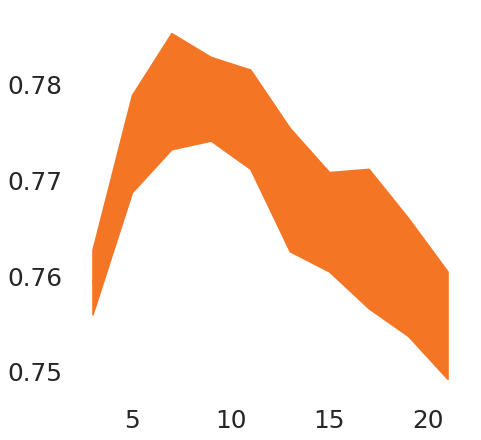

In [29]:
plt.figure(figsize=(7,7))
sns.set(style="white")
sns.set_context("talk", font_scale=1.5)
plt.rc('axes',edgecolor='#FFFFFF')

ax = sns.lineplot(x=np.array(tau_fall_x_axis), y=np.array(tau_fall_vs_efficiency).flatten(),
             linewidth=1, color='#F47524', ci='sd', err_style='band')

ax.get_children()[0].set_alpha(1.0)
# plt.xticks([])
# plt.yticks([])

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc_3a_file + ".png"))

In [30]:
mve.var_values_dict

{'1fa6afcb-3c25-4adf-90a1-96318d2adf53': {'syn_tau_fall_time': 7.0},
 '3aae3add-1e3e-4028-b961-d9510bb3acfe': {'syn_tau_fall_time': 5.0},
 '6ae208c5-497a-4ddd-9e5d-573695ad5f0f': {'syn_tau_fall_time': 9.0},
 '7eb000c9-e854-4be8-aa47-f9d28f95cf70': {'syn_tau_fall_time': 19.0},
 '9107fc70-3308-4291-a50d-ec0ce4c35005': {'syn_tau_fall_time': 11.0},
 '990c16e1-5557-469c-bd48-df3aac07568c': {'syn_tau_fall_time': 15.0},
 '9b429535-8a9a-440e-a32f-c05de86550ae': {'syn_tau_fall_time': 21.0},
 'a9b6a123-3800-40d3-8dd4-b492e264d653': {'syn_tau_fall_time': 3.0},
 'd22a32c4-dd27-4015-9c5e-59da56886f6e': {'syn_tau_fall_time': 13.0},
 'f87db52e-9ab6-4a71-9eac-f9dccf6b651c': {'syn_tau_fall_time': 17.0}}

In [ ]:
exp_uuid = '9b429535-8a9a-440e-a32f-c05de86550ae'
exp = mve.load_one_experiment(RESULTS_DIR, load_paper_8_file, exp_uuid)

In [32]:
np.percentile(exp.layer.W, [0,50,100])

array([-0.00730821,  0.00366255,  0.01539364])

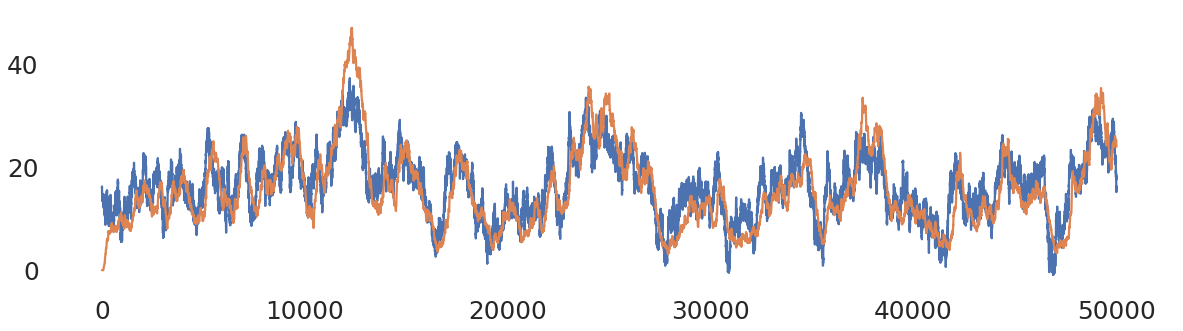

In [33]:
plt.figure(figsize=(20,5))

plt.plot(exp.inputs[:,0])
plt.plot(exp.outputs[:,0])

In [ ]:
DEPTH_START = 0
DEPTH = 5
DEPTH_STEP = 1

depths = range(DEPTH_START, DEPTH, DEPTH_STEP)
variables = {
    'depth': depths
}

test_t_stop = 10000.0

num_t = np.arange(0.0, test_t_stop, dt).shape[0]
network = PropagationNetwork.from_layer(exp.layer, DEPTH)
list_outs, list_V, list_F_binary, list_F_synaptic = network.output(test_i_inj, dt, test_t_stop)

efficiencies = np.empty((DEPTH))
in_fr = None

for d in depths:
    graph_psth(list_F_binary[d], 10000, save=os.path.join(GRAPHS_DIR, "syn_tau_fall=21__propnet_layer" + str(d) + "_spikes.png"), color="#2598B2")
    
    efficiencies[d-1] = 1.0 - np.linalg.norm(out-test_i_inj)/np.linalg.norm(test_i_inj)
    
    if in_fr is None:
        in_fr = layer.firing_rate(list_F_binary[0], dt, test_t_stop)
    out_fr = layer.firing_rate(list_F_binary[d+1], dt, test_t_stop)
    
    graph_firing_rates(in_fr, out_fr, 10000, save=os.path.join(GRAPHS_DIR, "syn_tau_fall=21__propnet_layer" + str(d) + "_fr.png"))

## EXPERIMENT
Exploratory 3b: Is the layer learning the mechanics of OU?

In [ ]:
i_white = np.random.normal(0, 1, i_inj.shape) #16.0 + 6.0*
out_white, _, _, _ = layer.output(i_white, dt, t_stop)

In [ ]:
i_white.shape

In [ ]:
SAMPLE_LEN = 1000
dt_secs = dt / 1000.0
# fft_N = np.arange(0.0, SAMPLE_LEN, dt).shape[0]

i_inj_fft = scipy.fftpack.fft(i_inj[:SAMPLE_LEN, 0])
i_white_fft = scipy.fftpack.fft(i_white[:SAMPLE_LEN, 0])

ou_output_fft = scipy.fftpack.fft(out[:SAMPLE_LEN, 0])
white_output_fft = scipy.fftpack.fft(out_white[:SAMPLE_LEN, 0])

xf = np.linspace(0.0, 1.0/(2.0*dt_secs), SAMPLE_LEN/2)

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

FREQ_START = 0
FREQ_END = 20 # SAMPLE_LEN//2

axs[0, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_inj_fft[FREQ_START:FREQ_END]))
axs[0, 0].set_title('TRAIN INPUT: OU-Process; Tau=50')
axs[0, 0].set_xlabel('Freq (Hz)')
axs[0, 0].set_ylabel('Rel. Amplitude')
axs[1, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(ou_output_fft[FREQ_START:FREQ_END]))
axs[1, 0].title.set_text('OUTPUT: OU-Process; Tau=50')
axs[1, 0].set_xlabel('Freq (Hz)')
axs[1, 0].set_ylabel('Rel. Amplitude')

axs[0, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_white_fft[FREQ_START:FREQ_END]))
axs[0, 1].set_title('INPUT: White Noise (sampled from N(0,1))')
axs[0, 1].set_xlabel('Freq (Hz)')
axs[0, 1].set_ylabel('Rel. Amplitude')
axs[1, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(white_output_fft[FREQ_START:FREQ_END]))
axs[1, 1].set_title('OUTPUT: White Noise (sampled from N(0,1))')
axs[1, 1].set_xlabel('Freq (Hz)')
axs[1, 1].set_ylabel('Rel. Amplitude')

plt.show()
# plt.savefig('fft_ou_vs_white_full.png')

In [ ]:
white_layer = Layer(NUM_NEURONS)
white_layer.train(i_inj=i_white, exp_output=i_white, dt=dt, t_stop=t_stop)
white_out, white_V, white_F_binary, white_F_synaptic = white_layer.output(i_inj, dt, t_stop)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(i_white[:10000])
plt.plot(white_out[:10000], 'plum')
plt.show()

In [ ]:
ou_through_white, _, _, _ = white_layer.output(i_inj, dt, t_stop)

In [ ]:
SAMPLE_LEN = 1000
dt_secs = dt / 1000.0
# fft_N = np.arange(0.0, SAMPLE_LEN, dt).shape[0]

i_inj_fft = scipy.fftpack.fft(i_inj[:SAMPLE_LEN, 0])
i_white_fft = scipy.fftpack.fft(i_white[:SAMPLE_LEN, 0])

ou_output_fft = scipy.fftpack.fft(ou_through_white[:SAMPLE_LEN, 0])
white_output_fft = scipy.fftpack.fft(white_out[:SAMPLE_LEN, 0])

xf = np.linspace(0.0, 1.0/(2.0*dt_secs), SAMPLE_LEN/2)

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

FREQ_START = 0
FREQ_END = 20 # SAMPLE_LEN//2

axs[0, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_white_fft[FREQ_START:FREQ_END]))
axs[0, 0].set_title('TRAIN INPUT: White Noise (sampled from N(0,1))')
axs[0, 0].set_xlabel('Freq (Hz)')
axs[0, 0].set_ylabel('Rel. Amplitude')
axs[1, 0].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(white_output_fft[FREQ_START:FREQ_END]))
axs[1, 0].set_title('OUTPUT: White Noise (sampled from N(0,1))')
axs[1, 0].set_xlabel('Freq (Hz)')
axs[1, 0].set_ylabel('Rel. Amplitude')

axs[0, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(i_inj_fft[FREQ_START:FREQ_END]))
axs[0, 1].set_title('INPUT: OU-Process; Tau=50')
axs[0, 1].set_xlabel('Freq (Hz)')
axs[0, 1].set_ylabel('Rel. Amplitude')
axs[1, 1].plot(xf[FREQ_START:FREQ_END], 2.0/fft_N * np.abs(ou_output_fft[FREQ_START:FREQ_END]))
axs[1, 1].title.set_text('OUTPUT: OU-Process; Tau=50')
axs[1, 1].set_xlabel('Freq (Hz)')
axs[1, 1].set_ylabel('Rel. Amplitude')

plt.show()
# plt.savefig('fft_ou_vs_white_full.png')

### EXPERIMENT: How does amount of training data affect the weights?

In [ ]:
import time

start_time = time.time()
loop_time = start_time

t_stop_var = 20.0e3

weights_v_training_t = []
training_ts = np.arange(1.0e3, 81.0e3, 10.0e3)

for t_stop_var in training_ts:
    # Slow Signal: INPUT
    input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop_var, 1)
    i_inj = 16.0 + 6.0*input_slow
    layer_var = Layer(NUM_NEURONS)
    layer_var.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop_var)
    
    weights_v_training_t += [layer_var.W]
    
    print("Training data length: ", t_stop_var)
    print("Iter time: ", time.time() - loop_time)
    print("Total time: ", time.time() - start_time)
    print("\n")
    loop_time = time.time()

In [ ]:
np.savez(open(os.path.join(RESULTS_DIR, "exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.npz"), 'wb'),
            weights_v_training_t=weights_v_training_t,
            training_ts=training_ts
        )

In [ ]:
exp_data = np.load(open(os.path.join(RESULTS_DIR, "exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.npz"), 'rb'))
weights_v_training_t = exp_data['weights_v_training_t'].tolist()
training_ts = exp_data['training_ts']

In [ ]:
plt.figure(figsize=(10,7))

sns.boxplot(x=training_ts/1000.0, y=weights_v_training_t, notch=True, sym="o", palette=sns.light_palette("red orange", input="xkcd", reverse=True, n_colors=8))# palette="Paired")
plt.title('Synaptic Weight Distribution vs Amount of Training Data', fontsize=15)
plt.xlabel('Training Data (seconds)')
plt.ylabel('Synaptic Weight')

# plt.show()
plt.savefig("exp__neurons=200__input=tau_50_same__t_stop=[1.0e3, 61.0e3, 10.0e3]_msecs.png")

We find that the the weights center around a certain value regardless of amount of training data, but observe a decrease in standard deviation with increased training data (***Fig 3a***). This is consistent with (insert citation here) 